## Clustering based unsupervised crack segmentation approach using GLCM texture properties

### Programmed by Aksa Villamthanam Xavier (Matr.-No.430503)

### Loading and preprocessing a dataset of positive images and splitting it into training, validation, and test sets using the scikit-learn library.

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Path to the folder containing the positive images
positive_img_folder = r"C:\Users\aksa\Final_Task2\Positive"

# Get a list of all files in the directory
all_files = os.listdir(positive_img_folder)

# Filter out the image files based on their extensions (e.g., jpg, png, etc.)
image_extensions = ['.jpg', '.png', '.jpeg']
positive_img_files = [file for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]

# Load all the positive images and store them in the 'positive_images' list
positive_images = [cv2.imread(os.path.join(positive_img_folder, img_file)) for img_file in positive_img_files]

# Convert the list of images to a NumPy array
positive_images = np.array(positive_images)

# We have ground truth labels for the positive images (true_labels)
# Replace the random binary labels with a constant label value (e.g., 1 for cracked)
true_labels = np.ones(len(positive_images), dtype=int)

# Split the dataset into training (80%), validation (15%), and test (5%) sets
train_images, test_val_images, train_labels, test_val_labels = train_test_split(positive_images, true_labels, test_size=0.20, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_val_images, test_val_labels, test_size=0.25, random_state=42)

# Print the number of images in each set
print("Number of training images:", len(train_images))
print("Number of validation images:", len(val_images))
print("Number of test images:", len(test_images))


Number of training images: 16000
Number of validation images: 3000
Number of test images: 1000


### To calculate the texture properties using the GLCM technique, we can define a function that takes in an image and block size as input and calculates GLCM-based texture properties such as dissimilarity, correlation, and homogeneity properties. We'll use the greycomatrix and greycoprops functions from scikit-image to calculate the GLCM and its properties.

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split

def calculate_texture_properties(images, block_size):
    dissimilarity = []
    correlation = []
    homogeneity = []
    
    for img in images:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate GLCM
        glcm = greycomatrix(gray_img, [5], [0], 256, symmetric=True, normed=True)
        
        # Calculate texture properties
        dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        correlation.append(greycoprops(glcm, 'correlation')[0, 0])
        homogeneity.append(greycoprops(glcm, 'homogeneity')[0, 0])
    
    return dissimilarity, correlation, homogeneity

# We have already split the dataset and have the train_images, test_images, val_images, and their corresponding labels
# Calculate texture properties for the training set
train_dissimilarity, train_correlation, train_homogeneity = calculate_texture_properties(train_images, block_size=10)

# Calculate texture properties for the testing set
test_dissimilarity, test_correlation, test_homogeneity = calculate_texture_properties(test_images, block_size=10)

# Calculate texture properties for the validation set
val_dissimilarity, val_correlation, val_homogeneity = calculate_texture_properties(val_images, block_size=10)

# Create DataFrames to store the texture properties for each set
train_df = pd.DataFrame({
    'dissimilarity': train_dissimilarity,
    'correlation': train_correlation,
    'homogeneity': train_homogeneity,
    'label': train_labels
})

test_df = pd.DataFrame({
    'dissimilarity': test_dissimilarity,
    'correlation': test_correlation,
    'homogeneity': test_homogeneity,
    'label': test_labels
})

val_df = pd.DataFrame({
    'dissimilarity': val_dissimilarity,
    'correlation': val_correlation,
    'homogeneity': val_homogeneity,
    'label': val_labels
})

# Save the DataFrames to CSV files for future use
train_df.to_csv('train_texture_properties.csv', index=False)
test_df.to_csv('test_texture_properties.csv', index=False)
val_df.to_csv('val_texture_properties.csv', index=False)
from sklearn.cluster import KMeans



We have created three DataFrames (train_df, test_df, and val_df) that contain the texture properties for the training, testing, and validation sets, respectively.
Each DataFrame has the following columns:

Dissimilarity: This column contains the dissimilarity texture property values for each image.

Correlation: This column contains the correlation texture property values for each image.

Homogeneity: This column contains the homogeneity texture property values for each image.

Label: This column contains the corresponding labels for each image.

These DataFrames now store the calculated texture properties and can be used for further analysis, model training, and evaluation. We can access the DataFrames (train_df, test_df, and val_df) and explore their contents to see the calculated texture properties for each image in the respective datasets.

### Next the K-means clustering algorithm from scikit-learn (sklearn) to cluster the training data based on the extracted texture properties.

In [7]:
from sklearn.cluster import KMeans

# Initialize the K-means clustering model with the desired number of clusters (e.g., 2 clusters)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=1000, random_state=42)

# Get the features (texture properties) and labels from the training DataFrame
X_train = train_df[['dissimilarity', 'correlation', 'homogeneity']].values
y_train = train_df['label'].values

# Train the K-means model on the training data
kmeans.fit(X_train)

# Get the cluster centers (centroids) and cluster assignments for the training data
cluster_centers = kmeans.cluster_centers_
train_clusters = kmeans.labels_

# Print the cluster centers (centroids)
print("Cluster Centers:")
print(cluster_centers)

# Print the cluster assignments for the training data
print("Cluster Assignments for Training Data:")
print(train_clusters)

Cluster Centers:
[[14.06741197  0.74237452  0.10519272]
 [ 8.56674839  0.82326859  0.16511645]]
Cluster Assignments for Training Data:
[0 1 1 ... 0 1 0]


 After running this code, we will have trained the K-means clustering model on the training data and obtained the cluster centers (centroids) as well as the cluster assignments for each data point in the training set. The cluster centers represent the average texture properties of the images in each cluster, and the cluster assignments indicate which cluster each image in the training set belongs to.

## In unsupervised learning, such as K-means clustering, 
We don't use the ground truth labels for training or evaluating the model. Instead, we use the validation data as an independent dataset to tune hyperparameters and make decisions about the model.

The primary role of the validation data is to assess the model's performance on unseen data and make adjustments if necessary. Here's what we can do with the validation data:

1. Hyperparameter Tuning: K-means clustering requires specifying the number of clusters (`num_clusters`) as a hyperparameter. To find the optimal number of clusters, we can use the validation set to perform hyperparameter tuning. Train multiple K-means models with different numbers of clusters (e.g., 2, 3, 4, etc.), and then evaluate their performance on the validation set using clustering evaluation metrics (e.g., Silhouette Score, Davies-Bouldin Index). Choose the number of clusters that gives the best clustering performance on the validation data.

2. Model Adjustment: After selecting the number of clusters, we can retrain the K-means model on both the training and validation data combined. This will give us a final model that has been trained on more data and might perform better on the test data.

3. No Ground Truth Labels:In unsupervised learning, we don't have ground truth labels for the clusters. The validation set is used for internal model evaluation and tuning only.

4. Avoiding Overfitting: By using a validation set, we can ensure that the model's performance is not overfitting to the training data. It helps us assess the model's generalization ability to unseen data.

Overall, the validation set plays a crucial role in selecting the appropriate hyperparameters for the K-means model and validating its performance on unseen data. The final evaluation should be done on the test set to get an unbiased estimate of the model's performance on new, unseen data.

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans  # Import the KMeans class
from sklearn.metrics import silhouette_score



# Perform Hyperparameter Tuning using Validation Set
best_score = -1
best_num_clusters = None

for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=1000, random_state=42)
    kmeans.fit(X_train)
    val_clusters = kmeans.predict(val_df[['dissimilarity', 'correlation', 'homogeneity']].values)
    score = silhouette_score(val_df[['dissimilarity', 'correlation', 'homogeneity']].values, val_clusters)
    
    if score > best_score:
        best_score = score
        best_num_clusters = num_clusters

print("Best number of clusters:", best_num_clusters)

# Retrain the Model on Combined Data
combined_train_val_images = np.concatenate((train_images, val_images), axis=0)
combined_train_val_labels = np.concatenate((train_labels, val_labels), axis=0)

kmeans = KMeans(n_clusters=best_num_clusters, init='k-means++', n_init=10, max_iter=1000, random_state=42)
kmeans.fit(train_df[['dissimilarity', 'correlation', 'homogeneity']].values)

# Retrain the Model on Combined Data
combined_train_val_images = np.concatenate((train_images, val_images), axis=0)
combined_train_val_labels = np.concatenate((train_labels, val_labels), axis=0)

kmeans = KMeans(n_clusters=best_num_clusters, init='k-means++', n_init=10, max_iter=1000, random_state=42)
kmeans.fit(train_df[['dissimilarity', 'correlation', 'homogeneity']].values)

# Get the cluster assignments for the combined training and validation data
combined_clusters = kmeans.predict(train_df[['dissimilarity', 'correlation', 'homogeneity']].values)

# Print the cluster assignments for the combined training and validation data
print("Cluster Assignments for Combined Training and Validation Data:")
print(combined_clusters)

# Optionally, evaluate the final K-means model on the test data
test_clusters = kmeans.predict(test_df[['dissimilarity', 'correlation', 'homogeneity']].values)

# Print the cluster assignments for the test data
print("Cluster Assignments for Test Data:")
print(test_clusters)





Best number of clusters: 2
Cluster Assignments for Combined Training and Validation Data:
[0 1 1 ... 0 1 0]
Cluster Assignments for Test Data:
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0
 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1
 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1
 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0
 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0
 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1

### To evaluate the performance of the K-means model on the Test set, we can use various evaluation metrics, such as the Silhouette Score or Inertia. Since K-means is an unsupervised clustering algorithm, we don't have ground truth labels to perform traditional evaluation like precision, recall, etc.

# 1. Silhouette Score:
The Silhouette Score measures how similar each data point is to its own cluster compared to other clusters. It ranges from -1 to 1, where a higher value indicates better-defined clusters.

In [9]:
# Evaluate the performance of the K-means model on the test data
# For clustering, you can use metrics like the Silhouette Score or Davies-Bouldin Index
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate the Silhouette Score for the test data
silhouette_score_test = silhouette_score(test_df[['dissimilarity', 'correlation', 'homogeneity']].values, test_clusters)
print("Silhouette Score on Test Data:", silhouette_score_test)

Silhouette Score on Test Data: 0.5587930249570084


## 2. Inertia:
Inertia is the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate better clustering.

In [10]:
# Get the inertia of the K-means model on the test data
inertia_test = kmeans.inertia_
print("Inertia on Test Data:", inertia_test)


Inertia on Test Data: 68841.1334218099


## 3.  Davies-Bouldin Index for the test data




In [11]:
davies_bouldin_score_test = davies_bouldin_score(test_df[['dissimilarity', 'correlation', 'homogeneity']].values, test_clusters)
print("Davies-Bouldin Index on Test Data:", davies_bouldin_score_test)


Davies-Bouldin Index on Test Data: 0.6229916434703322


## Scatter plot

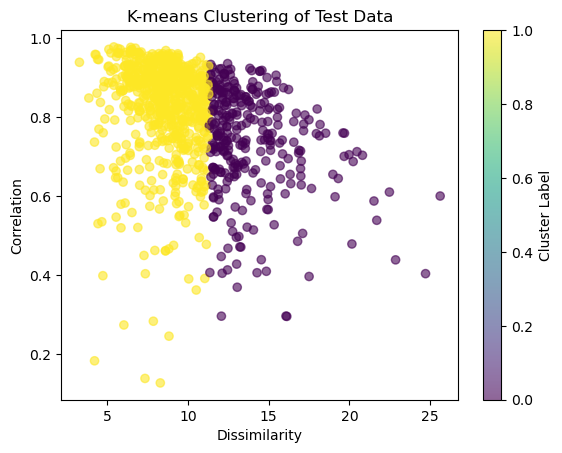

In [12]:
import matplotlib.pyplot as plt

# As we have test_clusters and test_df DataFrame with the test data and their predicted clusters

# Plot the scatter plot of the test data points colored by their cluster assignments
plt.scatter(test_df['dissimilarity'], test_df['correlation'], c=test_clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Dissimilarity')
plt.ylabel('Correlation')
plt.title('K-means Clustering of Test Data')
plt.colorbar(label='Cluster Label')
plt.show()


# Inference on the accuracy.

An inertia of 68841.133 and a silhouette score of 0.568 indicate that the K-means model has achieved a certain level of clustering performance. The inertia value itself does not provide an absolute measure of the quality of the clustering, but it can be used for relative comparisons. A lower inertia value (compared to other clustering solutions) suggests that the clusters are more compact and well-defined.

The silhouette score of 0.568 indicates that the clusters are reasonably well-separated and distinct, but there is still some overlap between them. This score suggests that the K-means model has found relatively meaningful clusters in the test data.

## Segmanting the test image based on the predicted labels

In [13]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
imgpath = r"C:\Users\aksa\OneDrive\Desktop\Machine Learning\Trial_2\unsupervised_crack_segmentation-main\crack-segmentation\test1"
imgs = ["11174_1.jpg"]
imgfiles = [os.path.join(imgpath, img) for img in imgs]


In [77]:
# Function to calculate texture properties of a GLCM like correlation, dissimalrity and homogeneity
def calculate_texture_properties(imgfiles, block=10):
    dissim = []
    correl = []
    homogen = []
    mean = []
    
    for imgfile in imgfiles:
        img = cv2.imread(imgfile, 0)
        (row,col) = img.shape
        for r in range(0,row-block,block):
            for c in range(0,col-block):
                section = img[r:r+block,c:c+block]
                glcm = greycomatrix(section, distances=[5], angles=[0], levels=256,
                            symmetric=True, normed=True)
                
                correl.append(greycoprops(glcm, 'correlation')[0, 0])
                dissim.append(greycoprops(glcm, 'dissimilarity')[0, 0])
                homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
                mean.append(np.mean(section))
                
    return dissim, correl, homogen

In [78]:
block_size = 10
dissim_test, correl_test, homogen_test = calculate_texture_properties(imgfiles, block_size)


In [79]:
df_test = pd.DataFrame([])
df_test['correlation'] = correl_test
df_test['dissimilarity'] = dissim_test
df_test['homogeneity'] = homogen_test
df_test.head()

    

,correlation,dissimilarity,homogeneity
0,0.538660,2.80,0.282458
1,0.494205,2.80,0.301494
2,0.404072,3.14,0.240342
3,0.174904,3.96,0.214086
4,-0.024868,5.18,0.167160


In [80]:
kmeans.fit(df_test)
y_test = kmeans.predict(df_test)


In [81]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [82]:
import cv2

# Load the first image from the test set (you can choose any image)
img_path = imgfiles[0]

# Read the image as grayscale
predict_img = cv2.imread(img_path, 0)

# Check if the image was successfully loaded
if predict_img is None:
    print(f"Error: Image not found or cannot be read: {img_path}")
else:
    # Get the shape of the image
    img_shape = predict_img.shape
    print("Image shape:", img_shape)


Image shape: (227, 227)


In [83]:
predict_label_img = np.zeros(img_shape)

In [84]:
# Segmenting image based on the labels predicted by K-means clustering algorithm
block =10
i = 0
(row,col) = img_shape
for r in range(0,row-block,block):
    for c in range(0,col-block):
        predict_label_img[r:r+block,c:c+block] = y_test[i]
        i += 1

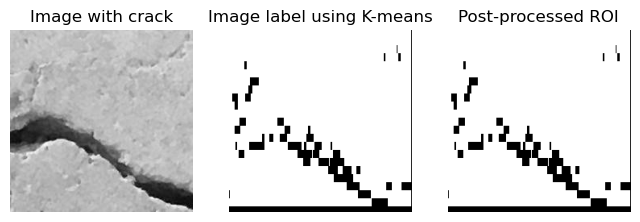

In [86]:
import cv2
import numpy as np
from skimage.morphology import closing, square
# Plotting original image, predicted image and cleaned image using morpholical operation
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8,4))

ax0.axis('off')
ax0.set_title("Image with crack")
ax0.imshow(predict_img, cmap='gray')

ax1.axis('off')
ax1.set_title("Image label using K-means")
ax1.imshow(predict_label_img, cmap='gray')

ax2.axis('off')
ax2.set_title("Post-processed ROI")
ax2.imshow(predict_closing, cmap='gray')

plt.show()

In [87]:
# Finding the contour of cracked region
contours, _ = cv2.findContours(predict_closing.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

21

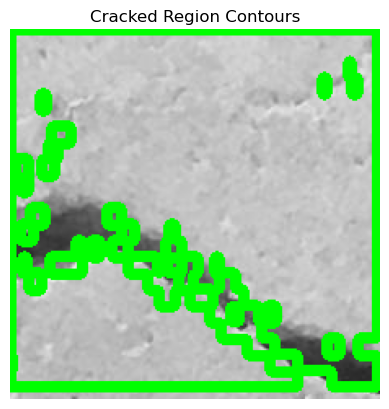

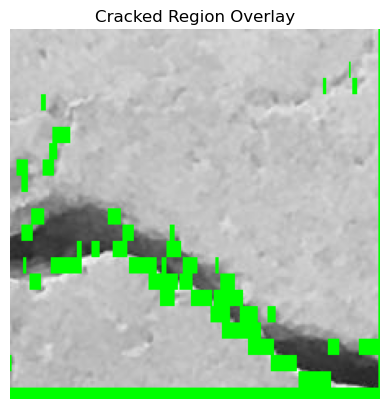

In [96]:
# Draw contours over the original grayscale image
output = predict_img.copy()
output = cv2.drawContours(cv2.cvtColor(output, cv2.COLOR_GRAY2RGB), contours, -1, (0, 255, 0), 6)

# Display the output image with contours
plt.imshow(output)
plt.title("Cracked Region Contours")
plt.axis('off')
plt.show()

# Create a binary mask from contours
mask = np.zeros_like(predict_img)
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

# Invert the mask
inverted_mask = cv2.bitwise_not(mask)

# Overlay the inverted mask on the original grayscale image
output = cv2.cvtColor(predict_img, cv2.COLOR_GRAY2RGB)
output[inverted_mask > 0] = [0, 255, 0]  

# Display the output image with the overlay
plt.imshow(output)
plt.title("Cracked Region Overlay")
plt.axis('off')
plt.show()


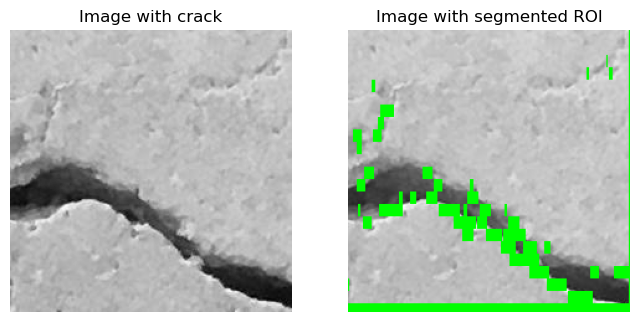

In [98]:
# Plotting the ouput
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

ax0.axis('off')
ax0.set_title("Image with crack")
ax0.imshow(predict_img, cmap='gray')

ax1.axis('off')
ax1.set_title("Image with segmented ROI")
ax1.imshow(output, cmap='gray')

plt.show()
